In [1]:
import os
import time
import shutil
import random
import cv2
import pandas as pd
import seaborn as sn
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from kaggle_datasets import KaggleDatasets
import warnings
warnings.filterwarnings("ignore")

2021-11-27 09:11:35.136419: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-27 09:11:35.136526: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
print('TF version:', tf.__version__)
print('Hub version:', hub.__version__)
print('Physical devices:', tf.config.list_physical_devices())

TF version: 2.4.1
Hub version: 0.12.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


2021-11-27 09:11:40.256814: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-27 09:11:40.259460: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-27 09:11:40.259489: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-27 09:11:40.259520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fcbdf5a4ac43): /proc/driver/nvidia/version does not exist


In [3]:
hub_url = 'gs://cloud-tpu-checkpoints/efficientnet/v2/hub/efficientnetv2-l-21k-ft1k/feature-vector'

In [4]:
AUTO = tf.data.experimental.AUTOTUNE

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-27 09:11:40.291563: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-27 09:11:40.293012: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-27 09:11:40.328121: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-27 09:11:40.328177: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30063}
2021-11-27 09:11:40.348127: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-27 09:11:40.348181: I tensorflow/co

REPLICAS:  8


In [5]:
EPOCHS = 10
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
WIDTH = 480
HEIGHT = 480
CHANNELS = 3
LEARNING_RATE = 0.001
CLASSES = 6
SEED = 32
top_dropout_rate = 0.2
AUTO = tf.data.experimental.AUTOTUNE

In [6]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path('fgvc8aug')
TRAIN_PATH = GCS_DS_PATH + "/data_full_augmentation_images/data_full_augmentation/images/"
print(GCS_DS_PATH)

gs://kds-2bef73751704c13199297869fb5ffba210239a19cc19f538e88a583f


In [7]:
final_model = 'EfficientNet_V2.h5'
hist_path = 'EfficientNet_V2_Hist.log'
train_image = '../input/fgvc8aug/data_full_augmentation_images/data_full_augmentation/images'
train_df = pd.read_csv('../input/fgvc8aug/data.csv', )

In [8]:
train_df = train_df[["image", "labels"]]
mlb = MultiLabelBinarizer().fit(train_df.labels.apply(lambda x : x.split()))
labels = pd.DataFrame(mlb.transform(train_df.labels.apply(lambda x : x.split())), columns = mlb.classes_)

labels = pd.concat([train_df['image'], labels], axis=1)
labels.head()

,image,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,c0c81ef5083faf1e_aug.jpg,0,1,0,0,0,0
1,c0c8c7270f638f9e_aug.jpg,0,0,1,0,0,0
2,c0c8cbbd163772d4_aug.jpg,0,1,0,0,0,0
3,c0c8679f29e519bc_aug.jpg,0,0,0,0,1,0
4,c0cac1de1be46f64_aug.jpg,1,0,0,0,0,0


In [9]:
def format_path(st):
    return TRAIN_PATH + st

train_paths = labels.image.apply(format_path).values

train_labels = np.float32(labels.loc[:, 'complex':'scab'].values)
train_paths, valid_paths, train_labels, valid_labels =\
train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [10]:
def process_img(filepath,label):
    image = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.convert_image_dtype(image, tf.float32) 
    image = tf.image.resize(image, [HEIGHT,WIDTH])
    return image,label

In [11]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(process_img, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(process_img, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

In [12]:
with strategy.scope():  
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape = [HEIGHT, WIDTH, 3]),
        hub.KerasLayer(hub_url, trainable = True),
        Dropout(top_dropout_rate, name = "top_dropout"),
        Dense(CLASSES, activation = 'sigmoid')
    ])
    model.build((None, HEIGHT, WIDTH, 3))
    model.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    model.summary()

2021-11-27 09:12:06.256376: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 09:12:06.342715: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 09:12:06.419221: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 09:12:06.490359: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.
2021-11-27 09:12:06.563511: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              117746848 
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 7686      
Total params: 117,754,534
Trainable params: 117,241,958
Non-trainable params: 512,576
_________________________________________________________________


In [13]:
checkpoint = ModelCheckpoint(
    final_model,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    save_weights_only= False ,
    perior = 1,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor = 'val_accuracy',
    mode = 'auto',
    min_delta = 0.0001,
    patience = 5,
    baseline = None,
    restore_best_weights = True,
    verbose = 1
)
def build_lrfn(lr_start=0.00001, lr_max=0.00005, 
               lr_min=0.00001, lr_rampup_epochs=5, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

In [14]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = train_labels.shape[0] // BATCH_SIZE
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [15]:
params = model.fit(
    train_dataset, 
    validation_data = valid_dataset, 
    epochs = EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks = [lr_schedule, early_stopping, checkpoint, CSVLogger(hist_path)]
)

Epoch 1/10

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
246/246 [==============================] - 1714s 6s/step - loss: 0.5544 - accuracy: 0.3716 - val_loss: 0.1461 - val_accuracy: 0.8450

Epoch 00001: val_accuracy improved from -inf to 0.84498, saving model to EfficientNet_V2.h5
Epoch 2/10

Epoch 00002: LearningRateScheduler reducing learning rate to 8.8e-05.
246/246 [==============================] - 672s 3s/step - loss: 0.1359 - accuracy: 0.8595 - val_loss: 0.0876 - val_accuracy: 0.9154

Epoch 00002: val_accuracy improved from 0.84498 to 0.91541, saving model to EfficientNet_V2.h5
Epoch 3/10

Epoch 00003: LearningRateScheduler reducing learning rate to 0.000166.
246/246 [==============================] - 694s 3s/step - loss: 0.0875 - accuracy: 0.9040 - val_loss: 0.0774 - val_accuracy: 0.9190

Epoch 00003: val_accuracy improved from 0.91541 to 0.91900, saving model to EfficientNet_V2.h5
Epoch 4/10

Epoch 00004: LearningRateScheduler reducing learning rate to 

In [16]:
def plot_hist(path):
  history = pd.read_csv(path)

  acc = history['accuracy']
  val_acc = history['val_accuracy']

  loss = history['loss']
  val_loss = history['val_loss']
  plt.style.use('fivethirtyeight')
  plt.figure(figsize=(20, 10))

  plt.subplot(1, 2, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.ylabel('Accuracy')
  plt.ylim([min(plt.ylim()), 1])
  plt.title('Training and Validation Accuracy')
  plt.xlabel('epoch')

  plt.subplot(1, 2, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.ylabel('Categorical Crossentropy')
  plt.ylim([min(plt.ylim()), max(plt.ylim())])
  plt.title('Training and Validation Loss')

  plt.xlabel('epoch')
  plt.savefig('evaluation.jpg')
  plt.show()

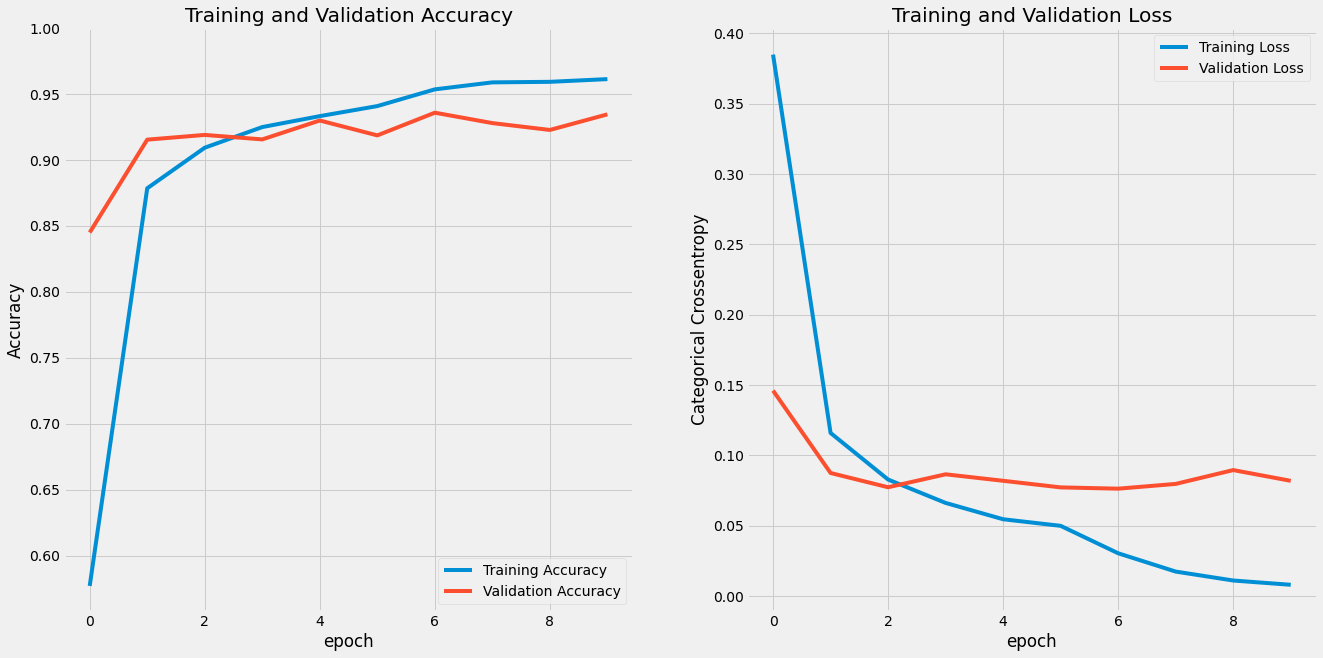

In [17]:
plot_hist("./EfficientNet_V2_Hist.log")